## Introduction


In this kaggle problem statement of Jigsaw/Conversation AI, **the problem of rating the severity of toxic comments is presented to us**. This is a follow-up to several competitions by Google’s jigsaw team which explores threats to open societies that are trying to help publishers and platforms worldwide to help in moderations of the content.


**Disclaimer:** The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

## Evaluation Criteria


Submissions are evaluated on Average Agreement with Annotators. For the ground truth, annotators were shown two comments and asked to identify which of the two was more toxic. Pairs of comments can be, and often are, rated by more than one annotator, and may have been ordered differently by different annotators.

For each of the approximately 300,000 pair ratings in the ground truth test data, we use your predicted toxicity score to rank the comment pair. The pair receives a 1 if this ranking matches the annotator ranking, or 0 if it does not match.

The final score is the average across all the pair evaluations.

Please note the following:

score is not constrained to any numeric range (e.g., you can predict [0, 1] or [-999, 999]).
There is no tie breaking; tied comment scores will always be evaluated as 0. You could consider using something like scipy.stats.rankdata to force unique value.

## Metrics used in buidling models 

The general metric which we are going to use is MarginRankingLoss , As we need to see which comment is more toxic as compared to others , there is a need to rank each of the comments on the basis of their toxicity .
Margin Ranking loss helps us attain that by ranking the toxic comments closer to other similar toxic comments and separating the lesser toxic comments


**Why not other alternative metrics ?**

There are other alternative metrics like MAE , RMSE or other such traditional metrics wouldn't be able to store the ranking ability like the Margin Ranking loss . 

Margin ranking loss has other alternaties like pairwise ranking loss , triplet ranking loss and multi modal ranking loss but they are limited to set number of data points and are not flexible in using to train large number of data points like in this case study

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator
from collections import defaultdict
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image
import seaborn as sns
import string
import plotly.figure_factory as ff
import random

In [3]:
df = pd.read_csv('/Users/rupesh/Downloads/Toxicity /jigsaw-toxic-severity-rating/validation_data.csv')

In [4]:
df

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook


As seen above , the comments are rated into either less_toxic or more_toxic by annotators . Our task is to predict the severity (rate the severity ) of the each respective comments.

In [5]:
print(f'Total workers involved in validation are => {len(df.worker.unique())}')


Total workers involved in validation are => 753


In [6]:
print(f'Less toxic unique comments => {len(df.less_toxic.unique())}')
print(f'More toxic unique comments => {len(df.more_toxic.unique())}')
print(f'Total unique comments in both columns => {len(df.more_toxic.append(df.less_toxic).unique())}')

Less toxic unique comments => 11532
More toxic unique comments => 11678
Total unique comments in both columns => 14251


Total unique comments are around 14K which were looked at by 753 workers

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from transformers import pipeline
import textstat
# from polyglot.detect import Detector

plt.style.use('ggplot')

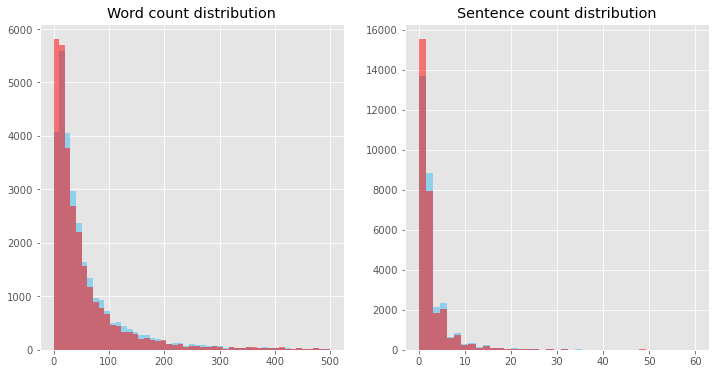

In [8]:
less_toxic_wc = df.less_toxic.apply(lambda comment: textstat.lexicon_count(str(comment)))
more_toxic_wc = df.more_toxic.apply(lambda comment: textstat.lexicon_count(str(comment)))

less_toxic_sc = df.less_toxic.apply(lambda comment: textstat.sentence_count(str(comment)))
more_toxic_sc = df.more_toxic.apply(lambda comment: textstat.sentence_count(str(comment)))

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
bins = np.linspace(0, 500, 50)
ax1.hist(less_toxic_wc, bins, alpha=0.9, label='less toxic wc', color = "skyblue")
ax1.hist(more_toxic_wc, bins, alpha=0.5, label='more toxic wc', color = "red")
ax1.set_title('Word count distribution')

ax2 = fig.add_subplot(122)
bins = np.linspace(0, 60, 40)
ax2.hist(less_toxic_sc, bins, alpha=0.9, label='less toxic wc', color = "skyblue")
ax2.hist(more_toxic_sc, bins, alpha=0.5, label='more toxic wc', color = "red")
ax2.set_title('Sentence count distribution')

plt.show()

The more toxic comments tend to be short whereas less toxic comments are longer. There's also quite a lot of overlapp.
Further, most comments have 1 or 2 sentences and there's very little to differentiate both classes here as well.

In [9]:
df['less_toxic'].value_counts() \
    .to_frame().head(5)

,less_toxic
"sorry i jumped to conclusions \n\non christian terrorism article man, I don't agree with you, and I want you to go and listen to 'prophet of doom' (now in audio format) as it is good. But I was wrong to be so rude. It is not the Southern European way.",13
How many sockpuppets do you have?,13
"An addition comment of interest by Andrew Coyne National Post Dec 7th regarding Dion's dual citizenship-“Anyone who questions Stephan Dion’s patriotism is either a fool or a scoundrel. After the service he has done this country, after the abuse he has suffered in its name, to cast even the slightest doubt on his loyalty to Canada shames those who would try. There can be few Canadians who believe in their country more, or have done more to defend it.” \nThis tactic that the PC's are using regarding the citizenship issue is very much a copy of the Republic book. If somewhere an article or sourced information could be found it could be of interest to add as a counterbalance.",12
"Sockpuppet\nHi, would you please confirm this sockpuppet using the wiki-tools at you disposal and close both of their accounts. \n\nhttp://en.wikipedia.org/wiki/Wikipedia:Sockpuppet_investigations/Yomangani\n\nThank you",12
this irishtom guy is turning every article into an ad for islam,12


In [10]:
df['more_toxic'].value_counts() \
    .to_frame().head(5)

more_toxic
 YOU SUCK \n\nI HATE YOU> YOU CAN FUCK MY ASS A...          14
STUPID SPANISH CENTRALISTSTUPID SPANISH CENTRAL...          14
MORON! The USA has only 5% of the worlds popula...          12
"\n\nBastard Child\nDoes anyone know if Obama w...          12
 INTEVIEW \n\nME: ARE YOU GAY?\n\nABE GAY DASHI...          12

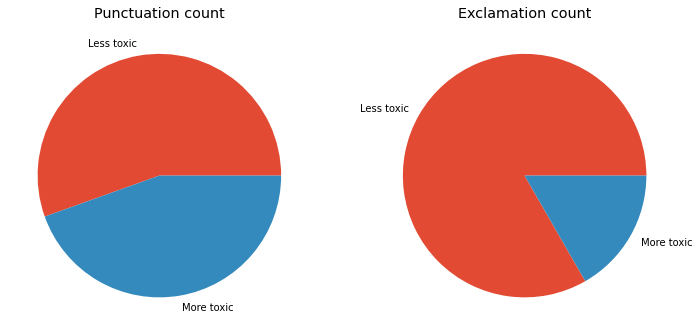

In [13]:
# all punctutaion count
#https://stackoverflow.com/questions/6969268/counting-letters-numbers-and-punctuation-in-a-string/14229674
punctuation_count = lambda l1,l2: sum([1 for x in l1 if x in l2])

df['less_toxic_punctuation_count'] = df.less_toxic.apply(lambda comment: punctuation_count(comment,set(string.punctuation)))
df['more_toxic_punctuation_count'] = df.more_toxic.apply(lambda comment: punctuation_count(comment,set(string.punctuation)))

# exclamation mark count
exclmataion_count = lambda l1: sum([1 for x in l1 if x =='!'])
df['less_toxic_exclmataion_count'] = df.less_toxic.apply(lambda comment: exclmataion_count(comment))
df['more_toxic_exclmataion_count'] = df.more_toxic.apply(lambda comment: exclmataion_count(comment))

punctuation_value_counts = df.apply(lambda row: 1 if row.more_toxic_punctuation_count > row.less_toxic_punctuation_count else 0, axis=1).value_counts()
exclamation_value_counts = df.apply(lambda row: 1 if row.more_toxic_exclmataion_count >= row.less_toxic_exclmataion_count else 0, axis=1).value_counts()

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121)
ax1.pie(punctuation_value_counts, labels = ['Less toxic', 'More toxic'])
ax1.set_title('Punctuation count')

ax2 = fig.add_subplot(122)
ax2.pie(exclamation_value_counts, labels = ['Less toxic', 'More toxic'])
ax2.set_title('Exclamation count')

plt.show()

Here we see that that the punctuation count in the less toxic is more than the more toxic comments which can indicate that the more toxic comments have less likelyhood of use of punctuatons , but its not much conclusive because there is near overlap together of both the categories

We also see that that the Exclamation count in the less toxic is more than the more toxic comments which can indicate that the more toxic comments have less likelyhood of use of punctuatons , but its much more conclusive because there is clear division of majority of less toxic comments of both the categories.

In [14]:
less_toxic_words = [len(sentence.split(' ')) for sentence in df['less_toxic'].values]
more_toxic_words = [len(sentence.split(' ')) for sentence in df['more_toxic'].values]

less_toxic_chars = [len(sentence) for sentence in df['less_toxic'].values]
more_toxic_chars = [len(sentence) for sentence in df['more_toxic'].values]

less_toxic_punct = [len([char for char in sentence if char in string.punctuation]) for sentence in df['less_toxic'].values]
more_toxic_punct = [len([char for char in sentence if char in string.punctuation]) for sentence in df['more_toxic'].values]


In [20]:
print("          Box plot of number of words   ")
fig = go.Figure()
fig.add_trace(go.Box(y=less_toxic_words, name = 'less_toxic',))
fig.add_trace(go.Box(y=more_toxic_words, name = 'more_toxic'))
fig.show()


          Box plot of number of words   


As we see there's no particular Distinguishable parts for the number of words in the data in each of the set of points of less and more toxic data , although there seems to be some small number of outliers in the more toxic dataset.

## Building a baseline model

#ref https://www.kaggle.com/julian3833/jigsaw-incredibly-simple-naive-bayes-0-768

In [21]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
df = pd.read_csv('/Users/rupesh/Downloads/Toxicity /jigsaw-toxic-severity-rating/validation_data.csv')

In [29]:
df

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook


In [38]:
k.head()

0              This article sucks \n\nwoo woo wooooooo
1    "And yes, people should recognize that but the...
2     Western Media?\n\nYup, because every crime in...
3    And you removed it! You numbskull! I don't car...
4     smelly vagina \n\nBluerasberry why don't you ...
Name: less_toxic, dtype: object

In [33]:
df

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook


I have not used the above given dataset , in using for a baseline predictins because it needs to be cleaned a lot , and there are multiple duplicates of the same points multiple times , which has resulted to very low scores , which I had overcomed by using the dataset from the comment classification dataset of the Jigsaw's older competition .

In [ ]:
df['y'].value_counts(normalize=True)

In [39]:
c_df = pd.read_csv("/Users/rupesh/Downloads/Toxicity /jigsaw-toxic-comment-classification-challenge/jigsaw-toxic-comment-train.csv")
c_df['y'] = (c_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
c_df = c_df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
c_df.sample(5)

,text,y
8104,"""\n\n Plain mistake: \n\n""""The amendment prohi...",0
3949,Hello \n\nI guess the reqeust for the lion vs ...,0
75175,"""\n\nI don't know anything about the issues su...",0
64770,Psycho Stalker\nHow dare you write such commen...,1
143983,"I'm very sorry, , that I will be unable to hel...",0


In [40]:
c_df['y'].value_counts(normalize=True)


0    0.899494
1    0.100506
Name: y, dtype: float64

In [42]:
vec = TfidfVectorizer()
X = vec.fit_transform(df['text'])
X

<223549x269340 sparse matrix of type '<class 'numpy.float64'>'
	with 9567250 stored elements in Compressed Sparse Row format>

In [43]:
nb_model = MultinomialNB()
nb_model.fit(X, df['y'])

MultinomialNB()

In [45]:
df_val = pd.read_csv("/Users/rupesh/Downloads/Toxicity /jigsaw-toxic-severity-rating/validation_data.csv")
X_less_toxic = vec.transform(df_val['less_toxic'])
X_more_toxic = vec.transform(df_val['more_toxic'])
p1 = nb_model.predict_proba(X_less_toxic)
p2 = nb_model.predict_proba(X_more_toxic)
# Validation Accuracy
(p1[:, 1] < p2[:, 1]).mean()

0.6279394180948585

**Why naive bias ?**

Because naive bias provides us with probability score for a classification task , it is one of the best models to train on a nlp data too , which makes it an ideal candidate for this problem's baseline model.

In [ ]:
orint("")